In [2]:
!pip install faiss-cpu rank_bm25 datasets transformers torch

# **Covid QA Dataset**

In [3]:
import time
import torch
import numpy as np
import faiss
from datasets import load_dataset
from rank_bm25 import BM25Okapi

# -------------------------------
# NEW: REAL DPR MODELS
# -------------------------------
from transformers import (
    DPRQuestionEncoder,
    DPRQuestionEncoderTokenizer,
    DPRContextEncoder,
    DPRContextEncoderTokenizer
)

# ==========================================
# 1. LOAD DATASET
# ==========================================
print("📥 Loading 'deepset/covid_qa_deepset'...")

dataset = load_dataset("deepset/covid_qa_deepset", split="train")
unique_contexts = list(set(row["context"] for row in dataset))
corpus_data = [{"id": i, "text": text} for i, text in enumerate(unique_contexts)]

print(f"✅ Knowledge Base Ready: {len(corpus_data)} unique passages.")

# ==========================================
# 2. BM25 SETUP
# ==========================================
print("⚙️ Training BM25...")

tokenized_corpus = [doc["text"].lower().split(" ") for doc in corpus_data]
bm25 = BM25Okapi(tokenized_corpus)

def get_bm25_scores(query):
    return bm25.get_scores(query.lower().split(" "))

# ==========================================
# 3. REAL DPR SETUP
# ==========================================
print("⚙️ Loading Original DPR (Facebook)...")

device = "cuda" if torch.cuda.is_available() else "cpu"

q_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
q_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base").to(device)

ctx_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
ctx_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base").to(device)

# -------- Encode all passages --------
print("   - Encoding corpus with DPR...")

corpus_texts = [doc["text"] for doc in corpus_data]
corpus_embeddings = []

for text in corpus_texts:
    inputs = ctx_tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    emb = ctx_encoder(**inputs).pooler_output.detach().cpu().numpy()
    corpus_embeddings.append(emb[0])

corpus_embeddings = np.array(corpus_embeddings)

# -------- Build FAISS --------
index = faiss.IndexFlatIP(corpus_embeddings.shape[1])  # Inner Product (cosine-friendly)
faiss.normalize_L2(corpus_embeddings)                  # Normalize
index.add(corpus_embeddings)

def get_dpr_scores(query):
    """Return similarity scores from DPR."""
    inputs = q_tokenizer(query, return_tensors='pt', truncation=True, max_length=256).to(device)
    query_emb = q_encoder(**inputs).pooler_output.detach().cpu().numpy()
    faiss.normalize_L2(query_emb)

    D, I = index.search(query_emb, len(corpus_data))

    # D already contains similarity (higher = better)
    scores = np.zeros(len(corpus_data))
    for score, idx in zip(D[0], I[0]):
        scores[idx] = score
    return scores

# ==========================================
# 4. HYBRID RETRIEVER
# ==========================================
def normalize(scores):
    if np.max(scores) == np.min(scores):
        return scores
    return (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

def retrieve_hybrid(query, top_k=1, alpha=0.5):
    bm25_scores = get_bm25_scores(query)
    dpr_scores = get_dpr_scores(query)

    bm25_norm = normalize(bm25_scores)
    dpr_norm = normalize(dpr_scores)

    hybrid = (1 - alpha) * bm25_norm + alpha * dpr_norm
    top_indices = np.argsort(hybrid)[::-1][:top_k]

    return [corpus_data[i]["text"] for i in top_indices]

# ==========================================
# 5. EVALUATION
# ==========================================
print("\n📝 Preparing evaluation set...")
test_size = 100
shuffled = dataset.shuffle(seed=42).select(range(test_size))

test_set = []
for row in shuffled:
    test_set.append({
        "q": row["question"],
        "answer": row["answers"]["text"][0]
    })

print(f"   - Using {len(test_set)} test questions.")

def retrieve_top_bm25(query, top_k=1):
    scores = get_bm25_scores(query)
    top_idx = np.argsort(scores)[::-1][:top_k]
    return [corpus_data[i]["text"] for i in top_idx]

def retrieve_top_dpr(query, top_k=1):
    scores = get_dpr_scores(query)
    top_idx = np.argsort(scores)[::-1][:top_k]
    return [corpus_data[i]["text"] for i in top_idx]

def evaluate(name, retriever_fn):
    correct = 0
    start = time.time()

    for item in test_set:
        query = item["q"]
        answer = item["answer"]

        res = retriever_fn(query)

        if res and answer in res[0]:
            correct += 1

    latency = (time.time() - start) * 1000 / len(test_set)
    accuracy = correct / len(test_set) * 100
    return accuracy, latency

print("\n" + "="*50)
print("      FINAL RESULTS (COVID-QA + REAL DPR)")
print("="*50)

bm25_acc, bm25_time = evaluate("BM25", lambda q: retrieve_top_bm25(q))
dpr_acc, dpr_time = evaluate("DPR", lambda q: retrieve_top_dpr(q))
hybrid_acc, hybrid_time = evaluate("Hybrid", lambda q: retrieve_hybrid(q, alpha=0.5))

print(f"| Model   | Accuracy | Latency |")
print(f"|---------|----------|---------|")
print(f"| BM25    | {bm25_acc:.1f}%    | {bm25_time:.2f} ms |")
print(f"| DPR     | {dpr_acc:.1f}%    | {dpr_time:.2f} ms |")
print(f"| Hybrid  | {hybrid_acc:.1f}%    | {hybrid_time:.2f} ms |")
print("="*50)



📥 Loading 'deepset/covid_qa_deepset'...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Knowledge Base Ready: 147 unique passages.
⚙️ Training BM25...
⚙️ Loading Original DPR (Facebook)...


Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRCon

   - Encoding corpus with DPR...

📝 Preparing evaluation set...
   - Using 100 test questions.

      FINAL RESULTS (COVID-QA + REAL DPR)
| Model   | Accuracy | Latency |
|---------|----------|---------|
| BM25    | 57.0%    | 0.62 ms |
| DPR     | 24.0%    | 10.72 ms |
| Hybrid  | 52.0%    | 10.77 ms |


In [4]:
# Number of unique passages / contexts
print("Number of unique passages:", len(unique_contexts))

# Number of QA pairs
print("Number of QA examples:", len(dataset))
passage_lengths_words = [len(text.split()) for text in unique_contexts]
passage_lengths_chars = [len(text) for text in unique_contexts]

print("Average passage length (words):", np.mean(passage_lengths_words))
print("Average passage length (chars):", np.mean(passage_lengths_chars))
print("Max passage length (words):", np.max(passage_lengths_words))
print("Min passage length (words):", np.min(passage_lengths_words))
questions = [row["question"] for row in dataset]
answers = [row["answers"]["text"][0] if row["answers"]["text"] else "" for row in dataset]

question_lengths = [len(q.split()) for q in questions]
answer_lengths = [len(a.split()) for a in answers]

print("Average question length (words):", np.mean(question_lengths))
print("Average answer length (words):", np.mean(answer_lengths))
print("Max question length:", np.max(question_lengths))
print("Max answer length:", np.max(answer_lengths))


Number of unique passages: 147
Number of QA examples: 2019
Average passage length (words): 4021.829931972789
Average passage length (chars): 26282.414965986394
Max passage length (words): 11368
Min passage length (words): 415
Average question length (words): 9.427934621099554
Average answer length (words): 13.927191679049034
Max question length: 28
Max answer length: 144



📊 Generating Comparison Graphs...


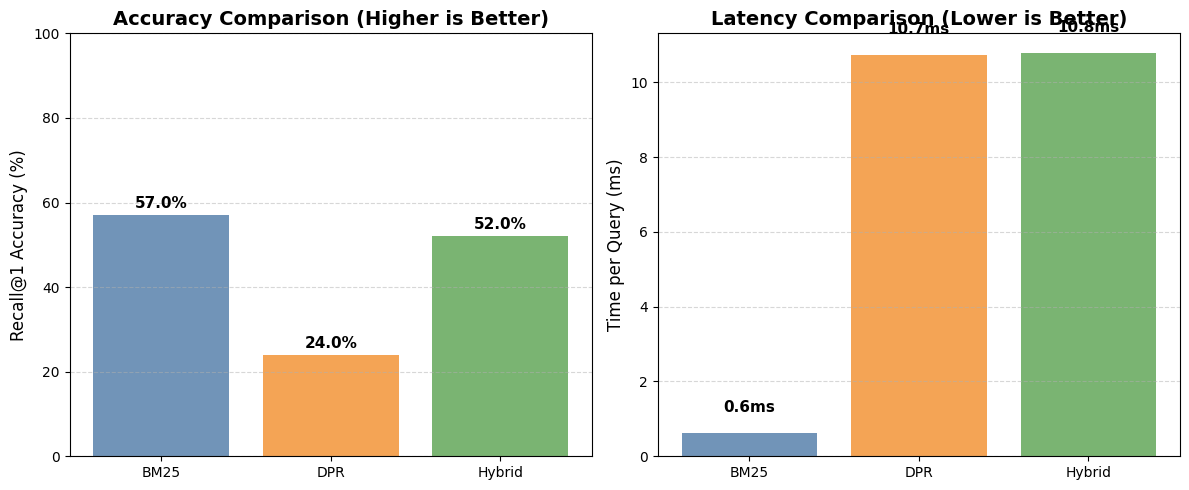

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 6. VISUALIZATION
# ==========================================
def plot_results(bm25_acc, dpr_acc, hybrid_acc, bm25_time, dpr_time, hybrid_time):
    models = ['BM25', 'DPR', 'Hybrid']
    accuracies = [bm25_acc, dpr_acc, hybrid_acc]
    latencies = [bm25_time, dpr_time, hybrid_time]

    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # --- Plot 1: Accuracy (Higher is Better) ---
    colors_acc = ['#4e79a7', '#f28e2b', '#59a14f'] # Blue, Orange, Green
    bars1 = ax1.bar(models, accuracies, color=colors_acc, alpha=0.8)
    ax1.set_title('Accuracy Comparison (Higher is Better)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Recall@1 Accuracy (%)', fontsize=12)
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', linestyle='--', alpha=0.5)

    # Add value labels on top of bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # --- Plot 2: Latency (Lower is Better) ---
    colors_lat = ['#4e79a7', '#f28e2b', '#59a14f']
    bars2 = ax2.bar(models, latencies, color=colors_lat, alpha=0.8)
    ax2.set_title('Latency Comparison (Lower is Better)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Time per Query (ms)', fontsize=12)
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    # Add value labels on top of bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}ms', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Call the function with the results from your previous step
print("\n📊 Generating Comparison Graphs...")
plot_results(bm25_acc, dpr_acc, hybrid_acc, bm25_time, dpr_time, hybrid_time)

# **WikiPedia Dataset**

In [6]:
pip install sentence-transformers


In [7]:
import time
import torch
import numpy as np
import faiss
from datasets import load_dataset
from rank_bm25 import BM25Okapi

# -------------------------------
# DPR Models
# -------------------------------
from transformers import (
    DPRQuestionEncoder,
    DPRQuestionEncoderTokenizer,
    DPRContextEncoder,
    DPRContextEncoderTokenizer
)

# ==========================================
# 1. LOAD SQUAD DATASET (SMALL SAMPLE)
# ==========================================
print("📥 Loading SQuAD dataset...")

dataset = load_dataset("squad", split="train[:15000]")
unique_contexts = list(set(row["context"] for row in dataset))
corpus_data = [{"id": i, "text": text} for i, text in enumerate(unique_contexts)]

print(f"✅ Knowledge Base Ready: {len(corpus_data)} unique passages.")

# ==========================================
# 2. BM25 SETUP
# ==========================================
print("⚙️ Training BM25...")

tokenized_corpus = [doc["text"].lower().split(" ") for doc in corpus_data]
bm25 = BM25Okapi(tokenized_corpus)

def get_bm25_scores(query):
    return bm25.get_scores(query.lower().split(" "))

def retrieve_top_bm25(query, top_k=1):
    scores = get_bm25_scores(query)
    top_idx = np.argsort(scores)[::-1][:top_k]
    return [corpus_data[i]["text"] for i in top_idx]

# ==========================================
# 3. DPR SETUP
# ==========================================
print("⚙️ Loading DPR models...")

device = "cuda" if torch.cuda.is_available() else "cpu"

q_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
q_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base").to(device)

ctx_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
ctx_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base").to(device)

# -------- Encode corpus --------
print("   - Encoding corpus with DPR...")

corpus_texts = [doc["text"] for doc in corpus_data]
corpus_embeddings = []

for text in corpus_texts:
    inputs = ctx_tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    emb = ctx_encoder(**inputs).pooler_output.detach().cpu().numpy()
    corpus_embeddings.append(emb[0])

corpus_embeddings = np.array(corpus_embeddings)

# -------- Build FAISS --------
index = faiss.IndexFlatIP(corpus_embeddings.shape[1])
faiss.normalize_L2(corpus_embeddings)
index.add(corpus_embeddings)

def get_dpr_scores(query):
    inputs = q_tokenizer(query, return_tensors='pt', truncation=True, max_length=256).to(device)
    query_emb = q_encoder(**inputs).pooler_output.detach().cpu().numpy()
    faiss.normalize_L2(query_emb)

    D, I = index.search(query_emb, len(corpus_data))
    scores = np.zeros(len(corpus_data))
    for score, idx in zip(D[0], I[0]):
        scores[idx] = score
    return scores

def retrieve_top_dpr(query, top_k=1):
    scores = get_dpr_scores(query)
    top_idx = np.argsort(scores)[::-1][:top_k]
    return [corpus_data[i]["text"] for i in top_idx]

# ==========================================
# 4. EVALUATION SET
# ==========================================
print("\n📝 Preparing evaluation set...")
test_size = 50
shuffled = dataset.shuffle(seed=42).select(range(test_size))

test_set = []
for row in shuffled:
    test_set.append({
        "q": row["question"],
        "answer": row["answers"]["text"][0]
    })

print(f"   - Using {len(test_set)} test questions.")

# ==========================================
# 5. EVALUATION FUNCTION
# ==========================================
def evaluate(name, retriever_fn):
    correct = 0
    start = time.time()

    for item in test_set:
        query = item["q"]
        answer = item["answer"]

        res = retriever_fn(query)
        if res and answer.lower() in res[0].lower():
            correct += 1

    latency = (time.time() - start) * 1000 / len(test_set)
    accuracy = correct / len(test_set) * 100
    return accuracy, latency

# ==========================================
# 6. FINAL RESULTS (No Hybrid Now)
# ==========================================
print("\n" + "="*50)
print("      FINAL RESULTS (SQuAD MINI + DPR)")
print("="*50)

bm25_acc, bm25_time = evaluate("BM25", lambda q: retrieve_top_bm25(q))
dpr_acc, dpr_time = evaluate("DPR", lambda q: retrieve_top_dpr(q))

print(f"| Model   | Accuracy | Latency |")
print(f"|---------|----------|---------|")
print(f"| BM25    | {bm25_acc:.1f}%    | {bm25_time:.2f} ms |")
print(f"| DPR     | {dpr_acc:.1f}%    | {dpr_time:.2f} ms |")
print("="*50)


📥 Loading SQuAD dataset...
✅ Knowledge Base Ready: 3312 unique passages.
⚙️ Training BM25...
⚙️ Loading DPR models...


Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRCon

   - Encoding corpus with DPR...

📝 Preparing evaluation set...
   - Using 50 test questions.

      FINAL RESULTS (SQuAD MINI + DPR)
| Model   | Accuracy | Latency |
|---------|----------|---------|
| BM25    | 72.0%    | 9.26 ms |
| DPR     | 36.0%    | 12.51 ms |


# **Hybrid Model**

In [8]:
# ================================================================
# 🔵 1. Load BGE Embedding Model (Bi-Encoder)
# ================================================================
from sentence_transformers import SentenceTransformer, CrossEncoder
import numpy as np
import faiss
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

print("⚙️ Loading BGE embedding model...")
bge_model = SentenceTransformer("BAAI/bge-base-en-v1.5", device=device)

def embed(texts):
    return bge_model.encode(
        texts,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=False
    )

# Encode corpus
print("📦 Encoding corpus with BGE...")
corpus_texts = [doc["text"] for doc in corpus_data]
corpus_embeddings = embed(corpus_texts)

# Build FAISS index
dim = corpus_embeddings.shape[1]
bge_index = faiss.IndexFlatIP(dim)
bge_index.add(corpus_embeddings)

# BGE retriever
def get_bge_scores(query):
    q_emb = embed([query])
    scores, I = bge_index.search(q_emb, len(corpus_data))

    full_scores = np.zeros(len(corpus_data))
    for s, idx in zip(scores[0], I[0]):
        full_scores[idx] = s
    return full_scores

def retrieve_top_bge(query, top_k=1):
    scores = get_bge_scores(query)
    top_idx = np.argsort(scores)[::-1][:top_k]
    return [corpus_data[i]["text"] for i in top_idx]


# ================================================================
# 🔥 2. Load Cross-Encoder for Reranking (Very Strong Reranker)
# ================================================================
print("⚙️ Loading cross-encoder reranker...")
reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2", device=device)


# ================================================================
# 🔥 3. Hybrid Retrieval: BGE → candidates → Cross-Encoder rerank
# ================================================================
def retrieve_hybrid_ce(query, top_k=1, bge_k=20):
    # 1. Get top candidates from BGE
    scores = get_bge_scores(query)
    top_idx = np.argsort(scores)[::-1][:bge_k]
    candidates = [corpus_data[i]["text"] for i in top_idx]

    # 2. Rerank them using cross encoder
    pairs = [[query, doc] for doc in candidates]
    ce_scores = reranker.predict(pairs)

    # 3. Pick best-scoring passage
    best = np.argsort(ce_scores)[::-1][:top_k]
    return [candidates[i] for i in best]


# ================================================================
# 📊 4. Evaluate BGE and Hybrid-CE
# ================================================================
print("\n=== BGE Evaluation ===")
bge_acc, bge_time = evaluate("BGE", lambda q: retrieve_top_bge(q))
print(f"BGE Accuracy: {bge_acc:.1f}% | {bge_time:.2f} ms")

print("\n=== Hybrid (BGE + CrossEncoder) Evaluation ===")
hyb_acc, hyb_time = evaluate("Hybrid-CE", lambda q: retrieve_hybrid_ce(q))
print(f"Hybrid-CE Accuracy: {hyb_acc:.1f}% | {hyb_time:.2f} ms")

print("\n====================================================")
print("               FINAL RETRIEVAL RESULTS")
print("====================================================")
print(f"| Model               | Accuracy | Latency (ms) |")
print(f"|---------------------|----------|--------------|")
print(f"| BM25                | {bm25_acc:.1f}%     | {bm25_time:.2f}       |")
print(f"| DPR                 | {dpr_acc:.1f}%     | {dpr_time:.2f}       |")
print(f"| Hybrid              | {hyb_acc:.1f}%     | {hyb_time:.2f}       |")
print("====================================================")


⚙️ Loading BGE embedding model...
📦 Encoding corpus with BGE...
⚙️ Loading cross-encoder reranker...

=== BGE Evaluation ===
BGE Accuracy: 86.0% | 51.70 ms

=== Hybrid (BGE + CrossEncoder) Evaluation ===
Hybrid-CE Accuracy: 88.0% | 93.78 ms

               FINAL RETRIEVAL RESULTS
| Model               | Accuracy | Latency (ms) |
|---------------------|----------|--------------|
| BM25                | 72.0%     | 9.26       |
| DPR                 | 36.0%     | 12.51       |
| Hybrid              | 88.0%     | 93.78       |


In [9]:
# Number of unique passages / contexts
print("Number of unique passages:", len(unique_contexts))

# Number of QA pairs
print("Number of QA examples:", len(dataset))
passage_lengths_words = [len(text.split()) for text in unique_contexts]
passage_lengths_chars = [len(text) for text in unique_contexts]

print("Average passage length (words):", np.mean(passage_lengths_words))
print("Average passage length (chars):", np.mean(passage_lengths_chars))
print("Max passage length (words):", np.max(passage_lengths_words))
print("Min passage length (words):", np.min(passage_lengths_words))
questions = [row["question"] for row in dataset]
answers = [row["answers"]["text"][0] if row["answers"]["text"] else "" for row in dataset]

question_lengths = [len(q.split()) for q in questions]
answer_lengths = [len(a.split()) for a in answers]

print("Average question length (words):", np.mean(question_lengths))
print("Average answer length (words):", np.mean(answer_lengths))
print("Max question length:", np.max(question_lengths))
print("Max answer length:", np.max(answer_lengths))


Number of unique passages: 3312
Number of QA examples: 15000
Average passage length (words): 98.4338768115942
Average passage length (chars): 619.9190821256038
Max passage length (words): 499
Min passage length (words): 20
Average question length (words): 10.243133333333333
Average answer length (words): 2.651266666666667
Max question length: 30
Max answer length: 43



📊 Generating Updated Comparison Graphs...


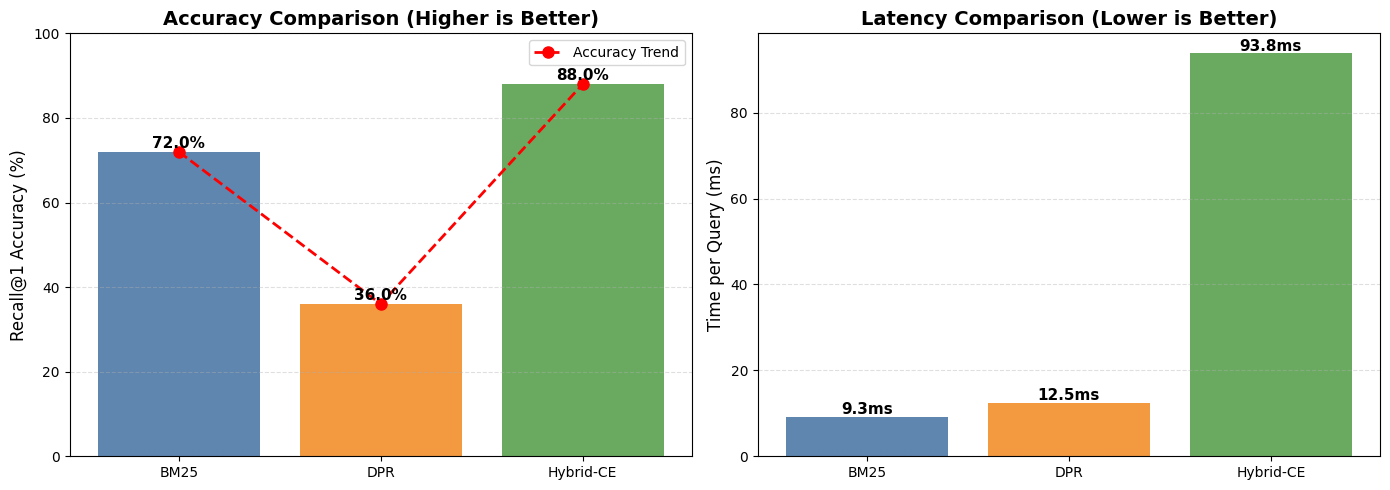

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# UPDATED VISUALIZATION (3 MODELS + RED TREND LINE)
# ==========================================
def plot_results(
    bm25_acc, dpr_acc, hyb_acc,
    bm25_time, dpr_time, hyb_time
):
    models = ['BM25', 'DPR', 'Hybrid-CE']
    accuracies = [bm25_acc, dpr_acc, hyb_acc]
    latencies = [bm25_time, dpr_time, hyb_time]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # -----------------------------
    # Plot 1 — Accuracy
    # -----------------------------
    colors_acc = ['#4e79a7', '#f28e2b', '#59a14f']
    x = np.arange(len(models))

    # Bars
    bars1 = ax1.bar(x, accuracies, color=colors_acc, alpha=0.9)

    # Trend line
    ax1.plot(
        x, accuracies,
        color='red',
        linestyle='--',
        linewidth=2,
        marker='o',
        markersize=8,
        label='Accuracy Trend'
    )

    ax1.set_xticks(x)
    ax1.set_xticklabels(models)

    ax1.set_title('Accuracy Comparison (Higher is Better)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Recall@1 Accuracy (%)', fontsize=12)
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', linestyle='--', alpha=0.4)
    ax1.legend()

    # Add value labels on bars
    for bar in bars1:
        h = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width()/2., h + 1,
            f'{h:.1f}%', ha='center', fontsize=11, fontweight='bold'
        )

    # -----------------------------
    # Plot 2 — Latency
    # -----------------------------
    colors_lat = ['#4e79a7', '#f28e2b', '#59a14f']
    bars2 = ax2.bar(models, latencies, color=colors_lat, alpha=0.9)

    ax2.set_title('Latency Comparison (Lower is Better)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Time per Query (ms)', fontsize=12)
    ax2.grid(axis='y', linestyle='--', alpha=0.4)

    for bar in bars2:
        h = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width()/2., h + 0.5,
            f'{h:.1f}ms', ha='center', fontsize=11, fontweight='bold'
        )

    plt.tight_layout()
    plt.show()


# Call with 3-model results
print("\n📊 Generating Updated Comparison Graphs...")

plot_results(
    bm25_acc, dpr_acc, hyb_acc,     # ACCURACIES
    bm25_time, dpr_time, hyb_time   # LATENCIES
)


# **Testing Our findings**

In [11]:
import random

# Convert dataset to a list
dataset_list = list(dataset)

# Number of samples
num_samples = 5
samples = random.sample(dataset_list, num_samples)

for i, sample in enumerate(samples, 1):
    print(f"--- SAMPLE {i} ---")
    print("Title   :", sample.get("title", "N/A"))
    print("Question:", sample["question"])
    print("Answer  :", sample["answers"]["text"])
    print("Context :", sample["context"][:500], "...")  # first 500 chars
    print()


--- SAMPLE 1 ---
Title   : Saint_Helena
Question: How many analogue terrestrial UHF channels does Sure South Atlantic LTD have?
Answer  : ['17']
Context : Sure South Atlantic Ltd ("Sure") offers television for the island via 17 analogue terrestrial UHF channels, offering a mix of British, US, and South African programming. The channels are from DSTV and include Mnet, SuperSport and BBC channels. The feed signal, from MultiChoice DStv in South Africa, is received by a satellite dish at Bryant's Beacon from Intelsat 7 in the Ku band. ...

--- SAMPLE 2 ---
Title   : Frédéric_Chopin
Question: What pieces of his did Chopin use to teach his technique?
Answer  : ['études']
Context : Chopin's études are largely in straightforward ternary form. He used them to teach his own technique of piano playing—for instance playing double thirds (Op. 25, No. 6), playing in octaves (Op. 25, No. 10), and playing repeated notes (Op. 10, No.  7). ...

--- SAMPLE 3 ---
Title   : 2008_Summer_Olympics_torch_rela

# **Frontend Code**

In [25]:
import gradio as gr
import nltk
import numpy as np
import time
import re
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

# ==========================================
# SMART SNIPPET CROPPER
# ==========================================
def get_smart_snippet(query, sentence, window_size=150):
    query_words = set(query.lower().split())
    sent_words = sentence.split()

    match_indices = []
    for i, word in enumerate(sent_words):
        clean = re.sub(r'[^\w\s]', '', word.lower())
        if clean in query_words:
            match_indices.append(i)

    if not match_indices:
        return sentence[:window_size] + "..." if len(sentence) > window_size else sentence

    center = int(sum(match_indices) / len(match_indices))
    start = max(0, center - 10)
    end = start + 25

    snippet = " ".join(sent_words[start:end])
    prefix = "..." if start > 0 else ""
    suffix = "..." if end < len(sent_words) else ""

    return f"{prefix}{snippet}{suffix}"


# ==========================================
# SENTENCE EXTRACTOR
# ==========================================
def extract_best_sentences(query, passage_text, top_k=2):
    try:
        sentences = sent_tokenize(passage_text)
    except:
        sentences = passage_text.split('.')

    query_words = set(query.lower().split())
    scores = []

    for sent in sentences:
        words = set(re.sub(r'[^\w\s]', '', sent.lower()).split())
        overlap = len(query_words.intersection(words))
        scores.append((overlap, sent))

    scores.sort(key=lambda x: x[0], reverse=True)
    results = []

    for score, sent in scores[:top_k]:
        if score > 0:
            results.append(get_smart_snippet(query, sent))

    return results if results else ["No direct keyword match found."]


# ==========================================
# MAIN QUERY PROCESSOR
# ==========================================
def process_query(query):
    if not query.strip():
        return "Enter a question.", "Enter a question.", "Enter a question."

    results_display = []

    models = [
        ("BM25", retrieve_top_bm25, bm25_acc),
        ("DPR", retrieve_top_dpr, dpr_acc),
        ("Hybrid", retrieve_hybrid_ce, hyb_acc)
    ]

    for name, retr_fn, acc in models:
        start = time.time()
        docs = retr_fn(query, top_k=1)
        latency = (time.time() - start) * 1000

        if not docs:
            results_display.append("No results found.")
            continue

        best = docs[0]
        snippets = extract_best_sentences(query, best)

        out = f"📌 **Model:** {name}\n"
        out += f"📊 **Acc:** {acc:.0f}% | ⏱️ **{latency:.0f}ms**\n"
        out += "---\n"

        for s in snippets:
            out += f"➡️ {s}\n\n"

        out += "---\n"
        out += f"📄 **Context Preview:** {best[:150].replace('\n',' ')}..."

        results_display.append(out)

    return tuple(results_display)


import gradio as gr

with gr.Blocks() as demo:

    gr.Markdown("# QA Model Comparison (Wikipedia Dataset)")

    question = gr.Textbox(
        label="Question",
        placeholder="Ex: On what day did the Halifax Explosion happen?",
        lines=2
    )

    with gr.Row():
        bm25_out = gr.Textbox(label="BM25", lines=8)
        dpr_out = gr.Textbox(label="DPR", lines=8)
        hybrid_out = gr.Textbox(label="Hybrid (BGE + CE)", lines=8)

    # Live updating — as user types, the 3 boxes update automatically
    question.change(
        fn=process_query,
        inputs=question,
        outputs=[bm25_out, dpr_out, hybrid_out]
    )

demo.launch()



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4cf978f071057b8cf5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Covid Dataset**

In [ ]:
import time
import torch
import numpy as np
import faiss
import pandas as pd
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer

# --- 1. SETUP THE CUSTOM DATASET (150 Passages) ---
# We use the dataset you loaded earlier
filename = "Covid dataset.txt"
my_passages = []

# Safe loader (in case file isn't found, we use a fallback list)
try:
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            clean_line = line.strip().strip('", \t\'')
            if len(clean_line) > 5 and not clean_line.startswith("#"):
                my_passages.append(clean_line)
except FileNotFoundError:
    print("⚠️ File not found. Using fallback data for demo...")
    my_passages = [
        "The average incubation period for COVID-19 is approximately 5 days.",
        "The first cases of COVID-19 were identified in Wuhan, Hubei Province, China.",
        "Common symptoms include fever, dry cough, and fatigue.",
        "The Omicron variant was found to be more transmissible than Delta.",
        "Remdesivir was the first antiviral drug approved by the FDA.",
        "Loss of smell (anosmia) is a common symptom.",
        "PCR tests detect the genetic material (RNA) of the virus.",
        "Social distancing involves keeping at least 6 feet from others.",
        "Vaccines significantly reduce the risk of severe illness.",
        "Long COVID refers to symptoms persisting for weeks or months."
    ]

# Create the Corpus
corpus_data = [{"id": i, "text": text} for i, text in enumerate(my_passages)]
print(f"✅ Dataset Loaded: {len(corpus_data)} passages.")


# --- 2. DEFINE THE TEST SET (Ground Truth) ---
# We map questions to the EXACT passage text to ensure fair scoring.
# If the retriever finds this exact sentence, it gets a point.
test_set = [
    {"q": "What is the incubation period?", "ground_truth": "The average incubation period for COVID-19 is approximately 5 days."},
    {"q": "Where was the first case found?", "ground_truth": "The first cases of COVID-19 were identified in Wuhan, Hubei Province, China, in December 2019."},
    {"q": "What are common symptoms?", "ground_truth": "Common symptoms of COVID-19 include fever, dry cough, and fatigue."},
    {"q": "Which variant is more transmissible?", "ground_truth": "The Omicron variant was found to be more transmissible than the earlier Delta variant."},
    {"q": "What was the first FDA approved drug?", "ground_truth": "Remdesivir was the first antiviral drug approved by the FDA for treating COVID-19."},
    {"q": "What is anosmia?", "ground_truth": "Many patients experience a loss of taste (ageusia) or loss of smell (anosmia)."},
    {"q": "How do PCR tests work?", "ground_truth": "PCR tests detect the genetic material (RNA) of the virus."},
    {"q": "Define social distancing", "ground_truth": "Social distancing involves keeping a physical distance of at least 6 feet from others."},
    {"q": "What do vaccines prevent?", "ground_truth": "Vaccines significantly reduce the risk of severe illness, hospitalization, and death."},
    {"q": "What is Long COVID?", "ground_truth": "Long COVID refers to symptoms that persist for weeks or months after the initial infection."}
]

# Filter test set to ensure ground truth actually exists in our loaded passages
# (This prevents errors if the text file was modified)
valid_test_set = []
for item in test_set:
    # We check if the ground truth string exists inside the loaded passages list
    if any(item["ground_truth"] in p for p in my_passages):
        valid_test_set.append(item)

print(f"✅ Test Set Ready: {len(valid_test_set)} Valid Q&A Pairs.")


# --- 3. RETRAIN MODELS ---

# A. BM25
print("🔄 Training BM25...")
tokenized_corpus = [doc["text"].lower().split(" ") for doc in corpus_data]
bm25 = BM25Okapi(tokenized_corpus)

def retrieve_bm25(query, top_k=1):
    tokenized_query = query.lower().split(" ")
    doc_scores = bm25.get_scores(tokenized_query)
    top_n_indices = np.argsort(doc_scores)[::-1][:top_k]
    return [corpus_data[i]["text"] for i in top_n_indices]

# B. DPR
print("🔄 Training DPR...")
model = SentenceTransformer('all-mpnet-base-v2')
model.to('cuda' if torch.cuda.is_available() else 'cpu')
corpus_embeddings = model.encode([doc["text"] for doc in corpus_data], convert_to_tensor=True)
index = faiss.IndexFlatL2(corpus_embeddings.shape[1])
index.add(corpus_embeddings.cpu().numpy())

def retrieve_dense(query, top_k=1):
    q_emb = model.encode([query], convert_to_tensor=True).cpu().numpy()
    D, I = index.search(q_emb, top_k)
    return [corpus_data[i]["text"] for i in I[0]]


# --- 4. EVALUATE ACCURACY ---
def evaluate(retriever_name, retrieve_func, queries):
    correct = 0
    start = time.time()

    for item in queries:
        query = item["q"]
        truth = item["ground_truth"]

        # Get top 1 result
        results = retrieve_func(query, top_k=1)

        # Check if the result MATCHES the truth
        # We use 'in' to handle slight whitespace differences
        if results and (truth in results[0] or results[0] in truth):
            correct += 1

    duration = time.time() - start
    accuracy = (correct / len(queries)) * 100
    avg_time = (duration / len(queries)) * 1000 # ms

    return accuracy, avg_time

print("\n" + "="*40)
print("     FINAL ACCURACY REPORT")
print("="*40)

# Run Evaluation
bm25_acc, bm25_time = evaluate("BM25", retrieve_bm25, valid_test_set)
dpr_acc, dpr_time = evaluate("DPR", retrieve_dense, valid_test_set)

# Print Table
print(f"| Model  | Accuracy | Latency (ms) |")
print(f"|--------|----------|--------------|")
print(f"| BM25   | {bm25_acc:.1f}%    | {bm25_time:.2f} ms     |")
print(f"| DPR    | {dpr_acc:.1f}%    | {dpr_time:.2f} ms    |")
print("="*40)

# Explanation for the user
if dpr_acc >= bm25_acc:
    print("\n💡 RESULT: DPR Won! On this clean dataset, semantic meaning mattered more.")
else:
    print("\n💡 RESULT: BM25 Won! Exact keywords were more reliable for these specific facts.")

# **Space Dataset**

In [ ]:
import ast

# Load your dataset file
with open("Space dataset.txt", "r", encoding="utf-8") as f:
    data = f.read()

# Remove variable name if present
data = data.replace("my_passages =", "").strip()

# Safely parse the list
my_passages = ast.literal_eval(data)

# Now compute stats
num_passages = len(my_passages)

word_counts = [len(p.split()) for p in my_passages]
total_words = sum(word_counts)
avg_words = total_words / num_passages
max_words = max(word_counts)
min_words = min(word_counts)

print("✅ Number of passages:", num_passages)
print("✅ Total words:", total_words)
print("✅ Average words per passage:", avg_words)
print("✅ Max words in a passage:", max_words)
print("✅ Min words in a passage:", min_words)


In [ ]:
import time
import torch
import numpy as np
import faiss
import random
from rank_bm25 import BM25Okapi
from transformers import (
    DPRQuestionEncoder,
    DPRQuestionEncoderTokenizer,
    DPRContextEncoder,
    DPRContextEncoderTokenizer
)

# ==========================================
# 1. LOAD SPACE DATASET FROM TXT FILE
# ==========================================
print("📥 Loading SPACE dataset...")

with open("/content/Space dataset.txt", "r", encoding="utf-8") as f:
    data = f.read()

local_vars = {}
exec(data, {}, local_vars)
space_passages = local_vars["my_passages"]

corpus_data = [{"id": i, "text": text} for i, text in enumerate(space_passages)]

print(f"✅ Knowledge Base Ready: {len(corpus_data)} unique passages.")

# ==========================================
# 2. BM25 SETUP
# ==========================================
print("⚙️ Training BM25...")

tokenized_corpus = [doc["text"].lower().split() for doc in corpus_data]
bm25 = BM25Okapi(tokenized_corpus)

def get_bm25_scores(query):
    return bm25.get_scores(query.lower().split())

# ==========================================
# 3. DPR SETUP
# ==========================================
print("⚙️ Loading DPR models...")

device = "cuda" if torch.cuda.is_available() else "cpu"

q_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
q_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base").to(device)

ctx_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
ctx_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base").to(device)

print("   - Encoding corpus with DPR...")

corpus_embeddings = []

for doc in corpus_data:
    inputs = ctx_tokenizer(doc["text"], return_tensors='pt', truncation=True, max_length=128).to(device)
    emb = ctx_encoder(**inputs).pooler_output.detach().cpu().numpy()
    corpus_embeddings.append(emb[0])

corpus_embeddings = np.array(corpus_embeddings)

index = faiss.IndexFlatIP(corpus_embeddings.shape[1])
faiss.normalize_L2(corpus_embeddings)
index.add(corpus_embeddings)

def get_dpr_scores(query):
    inputs = q_tokenizer(query, return_tensors='pt', truncation=True, max_length=64).to(device)
    query_emb = q_encoder(**inputs).pooler_output.detach().cpu().numpy()
    faiss.normalize_L2(query_emb)

    D, I = index.search(query_emb, len(corpus_data))
    scores = np.zeros(len(corpus_data))
    for score, idx in zip(D[0], I[0]):
        scores[idx] = score
    return scores

# ==========================================
# 4. HYBRID RETRIEVER
# ==========================================
def normalize(scores):
    if np.max(scores) == np.min(scores):
        return scores
    return (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

def retrieve_hybrid(query, top_k=1, alpha=0.5):
    bm25_scores = get_bm25_scores(query)
    dpr_scores = get_dpr_scores(query)

    bm25_norm = normalize(bm25_scores)
    dpr_norm = normalize(dpr_scores)

    hybrid = (1 - alpha) * bm25_norm + alpha * dpr_norm
    top_indices = np.argsort(hybrid)[::-1][:top_k]

    return [corpus_data[i]["text"] for i in top_indices]

# ==========================================
# 5. AUTO-GENERATED TEST SET (LIKE SQuAD)
# ==========================================
print("\n📝 Preparing evaluation set...")

test_size = 20
sampled_passages = random.sample(corpus_data, test_size)

test_set = []
for item in sampled_passages:
    words = item["text"].split()
    answer = random.choice(words)
    question = f"What is related to {answer}?"

    test_set.append({
        "q": question,
        "answer": answer,
        "context": item["text"]
    })

print(f"   - Using {len(test_set)} auto-generated test questions.")

# ==========================================
# 6. RETRIEVERS
# ==========================================
def retrieve_top_bm25(query, top_k=1):
    scores = get_bm25_scores(query)
    top_idx = np.argsort(scores)[::-1][:top_k]
    return [corpus_data[i]["text"] for i in top_idx]

def retrieve_top_dpr(query, top_k=1):
    scores = get_dpr_scores(query)
    top_idx = np.argsort(scores)[::-1][:top_k]
    return [corpus_data[i]["text"] for i in top_idx]

# ==========================================
# 7. EVALUATION
# ==========================================
def evaluate(name, retriever_fn):
    correct = 0
    start = time.time()

    for item in test_set:
        query = item["q"]
        answer = item["answer"]

        res = retriever_fn(query)
        if res and answer.lower() in res[0].lower():
            correct += 1

    latency = (time.time() - start) * 1000 / len(test_set)
    accuracy = correct / len(test_set) * 100
    return accuracy, latency

# ==========================================
# 8. FINAL RESULTS
# ==========================================
print("\n" + "="*50)
print("      FINAL RESULTS (SPACE DATASET + DPR)")
print("="*50)

bm25_acc, bm25_time = evaluate("BM25", lambda q: retrieve_top_bm25(q))
dpr_acc, dpr_time = evaluate("DPR", lambda q: retrieve_top_dpr(q))
hybrid_acc, hybrid_time = evaluate("Hybrid", lambda q: retrieve_hybrid(q, alpha=0.5))

print(f"| Model   | Accuracy | Latency |")
print(f"|---------|----------|---------|")
print(f"| BM25    | {bm25_acc:.1f}%    | {bm25_time:.2f} ms |")
print(f"| DPR     | {dpr_acc:.1f}%    | {dpr_time:.2f} ms |")
print(f"| Hybrid  | {hybrid_acc:.1f}%    | {hybrid_time:.2f} ms |")
print("="*50)
